In [14]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe
## Puxada dos dados modelados do processo de extração
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm

In [15]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(42)

In [16]:
## Puxada dos dados modelados do processo de extração
dados_modelo = rfe.read_file('features/dados_modelo.xlsx').get_df()


In [17]:
dados_linha = dados_modelo.query('categoria == "linha"')
dados_la = dados_modelo.query('categoria == "la"')
dados_armarinho = dados_modelo.query('categoria == "armarinho"')

In [18]:
print(dados_linha)
print(dados_la)
print(dados_armarinho)

      numero categoria   data_dia   ano  mes  mes_ano  quant_  qtd_norm  total
0      11637     linha 2020-09-13  2020    9  2020-09     4.0  0.003988   8.00
4      11646     linha 2020-09-13  2020    9  2020-09     2.0  0.001988  31.00
5      11645     linha 2020-09-13  2020    9  2020-09     2.0  0.001988  31.00
6      11650     linha 2020-09-13  2020    9  2020-09     2.0  0.001988  33.60
7      11643     linha 2020-09-13  2020    9  2020-09     2.0  0.001988  29.00
...      ...       ...        ...   ...  ...      ...     ...       ...    ...
9380   38243     linha 2022-07-29  2022    7  2022-07     7.0  0.006988  27.30
9384   38230     linha 2022-07-29  2022    7  2022-07     1.0  0.000988  21.00
9386   38229     linha 2022-07-29  2022    7  2022-07     2.0  0.001988  10.24
9388   38225     linha 2022-07-29  2022    7  2022-07     1.0  0.000988   3.00
9392   38251     linha 2022-07-30  2022    7  2022-07     2.0  0.001988   6.00

[4140 rows x 9 columns]
      numero categoria   da

In [55]:
#most sold product in each category by month
df = dados_modelo.groupby(['categoria', 'mes_ano', 'numero']).sum().reset_index().sort_values(by=['mes_ano','quant_'], ascending=False)
df

,categoria,mes_ano,numero,ano,mes,quant_,qtd_norm,total
3580,armarinho,2022-07,37569,2022,7,278.0,0.277991,60.00
3698,armarinho,2022-07,37998,2022,7,201.0,0.200990,53.59
3710,armarinho,2022-07,38025,2022,7,166.0,0.165990,31.75
3565,armarinho,2022-07,37522,2022,7,150.0,0.149990,26.85
3648,armarinho,2022-07,37781,2022,7,100.0,0.099989,6.00
...,...,...,...,...,...,...,...,...
5413,linha,2020-09,13315,2020,9,1.0,0.000988,16.50
5414,linha,2020-09,13317,2020,9,1.0,0.000988,2.00
5416,linha,2020-09,13356,2020,9,1.0,0.000988,16.50
5417,linha,2020-09,13365,2020,9,1.0,0.000988,16.11


In [67]:
df = dados_modelo.groupby(['categoria', 'mes_ano', 'numero']).sum().reset_index().sort_values(by=['mes_ano','quant_'], ascending=False)
df2 = df.query('categoria == "linha"')
df2['taxa_participacao'] = df.groupby(['categoria'])['quant_'].apply(lambda x: x/x.sum())

df2.sort_values(by=['taxa_participacao'], ascending=False)

,categoria,mes_ano,numero,ano,mes,quant_,qtd_norm,total,taxa_participacao
6696,linha,2021-05,22273,2021,5,70.0,0.069989,273.0,0.007619
8634,linha,2022-03,33444,2022,3,32.0,0.031988,124.8,0.003483
5987,linha,2020-12,18334,2020,12,30.0,0.029988,195.5,0.003265
5885,linha,2020-12,17922,2020,12,28.0,0.027988,96.6,0.003048
7463,linha,2021-09,27087,2021,9,27.0,0.026988,99.7,0.002939
...,...,...,...,...,...,...,...,...,...
7269,linha,2021-08,25570,2021,8,1.0,0.000988,24.0,0.000109
7273,linha,2021-08,25580,2021,8,1.0,0.000988,12.0,0.000109
7274,linha,2021-08,25583,2021,8,1.0,0.000988,5.5,0.000109
7275,linha,2021-08,25584,2021,8,1.0,0.000988,5.5,0.000109


## Estacionaridade 
A hipótese nula do teste é que a série temporal pode ser representada por uma raiz unitária, que não é estacionária (tem alguma estrutura dependente do tempo). A hipótese alternativa (rejeitar a hipótese nula) é que a série cronológica é estacionária.

Hipótese nula (H0): Se não for rejeitada, sugere que a série cronológica tem uma raiz unitária, o que significa que não é estacionária. Tem alguma estrutura dependente do tempo.
Hipótese alternativa (H1): A hipótese nula é rejeitada; sugere que a série cronológica não tem uma raiz unitária, o que significa que é estacionária. Não tem uma estrutura dependente do tempo.
Interpretamos este resultado utilizando o valor p do teste. Um valor p abaixo de um limiar (como 5% ou 1%) sugere que rejeitamos a hipótese nula (estacionária), caso contrário, um valor p acima do limiar sugere que não rejeitamos a hipótese nula (não estacionária).

* p-valor > 0,05: Não rejeitar a hipótese nula (H0), os dados têm uma raiz unitária e são não-estacionários.
* p-valor <= 0,05: Rejeitar a hipótese nula (H0), os dados não têm uma raiz unitária e são estacionários.

Referente ao teste de Dickey-Fulley é tido que se seu valor é menor que o valores críticos, tem-se sua significância estatística. Por exemplo, caso seu teste seja menor que o valor límitrofe dos seus 1% de seus valores críticos, 
isto sugere que podemos rejeitar a hipótese nula com um nível de significância inferior a 1% (ou seja, uma probabilidade baixa de que o resultado seja uma casualidade estatística).


In [20]:

def check_stationarity(ts):
    dftest = adfuller(ts)
    dftest2 = adfuller(ts.diff().dropna())
    dftest3 = adfuller(ts.diff().diff().dropna())
    adf = dftest[0]
    adf2 = dftest2[0]
    adf3 = dftest3[0]
    pvvalue = dftest[1]
    pvvalue2 = dftest2[1]
    pvvalue3 = dftest3[1]
    critical_value = dftest[4]
    critical_value2 = dftest2[4]
    critical_value3 = dftest3[4]
    print('Results of Dickey-Fuller Test:')
    print('Test Statistic: ', adf)
    print('p-value: ', pvvalue)
    print('Critical Values:')
    for key, value in critical_value.items():
	    print('\t%s: %.3f' % (key, value))
    print('Results of Dickey-Fuller Test 2:')
    print('Test Statistic: ', adf2)
    print('p-value: ', pvvalue2)
    print('Critical Values:')
    for key, value in critical_value2.items():
        print('\t%s: %.3f' % (key, value))

    print('Results of Dickey-Fuller Test 3:')
    print('Test Statistic: ', adf3)
    print('p-value: ', pvvalue3)
    print('Critical Values:')
    for key, value in critical_value3.items():
        print('\t%s: %.3f' % (key, value))

    return adf, adf2, adf3, pvvalue, pvvalue2, pvvalue3, critical_value, critical_value2, critical_value3
        
#    pvalue = dftest[1]
#   critical_value = dftest[4]['5%']
#   if (pvalue < 0.05) and (adf < critical_value):
#       print('The series is stationary')
#       print('ADF Statistic: %f' % dftest[0])
#       print('p-value: %f' % dftest[1])
#       print('Critical Values:')
#       for key, value in dftest[4].items():
#           print('\t%s: %.3f' % (key, value))
#
#   else:
#       print('The series is NOT stationary')
#       print('ADF Statistic: %f' % dftest[0])
#       print('p-value: %f' % dftest[1])
#       print('Critical Values:')
#       for key, value in dftest[4].items():
#           print('\t%s: %.3f' % (key, value))
#   


LINHA
Gráfico de Qtd de vendas por categoria
--------------------------------------------------
Gráficos de autocorrelação e autocorrelação parcial
--------------------------------------------------
Gráfico de autocorrelação
--------------------------------------------------
Gráfico de autocorrelação parcial
--------------------------------------------------


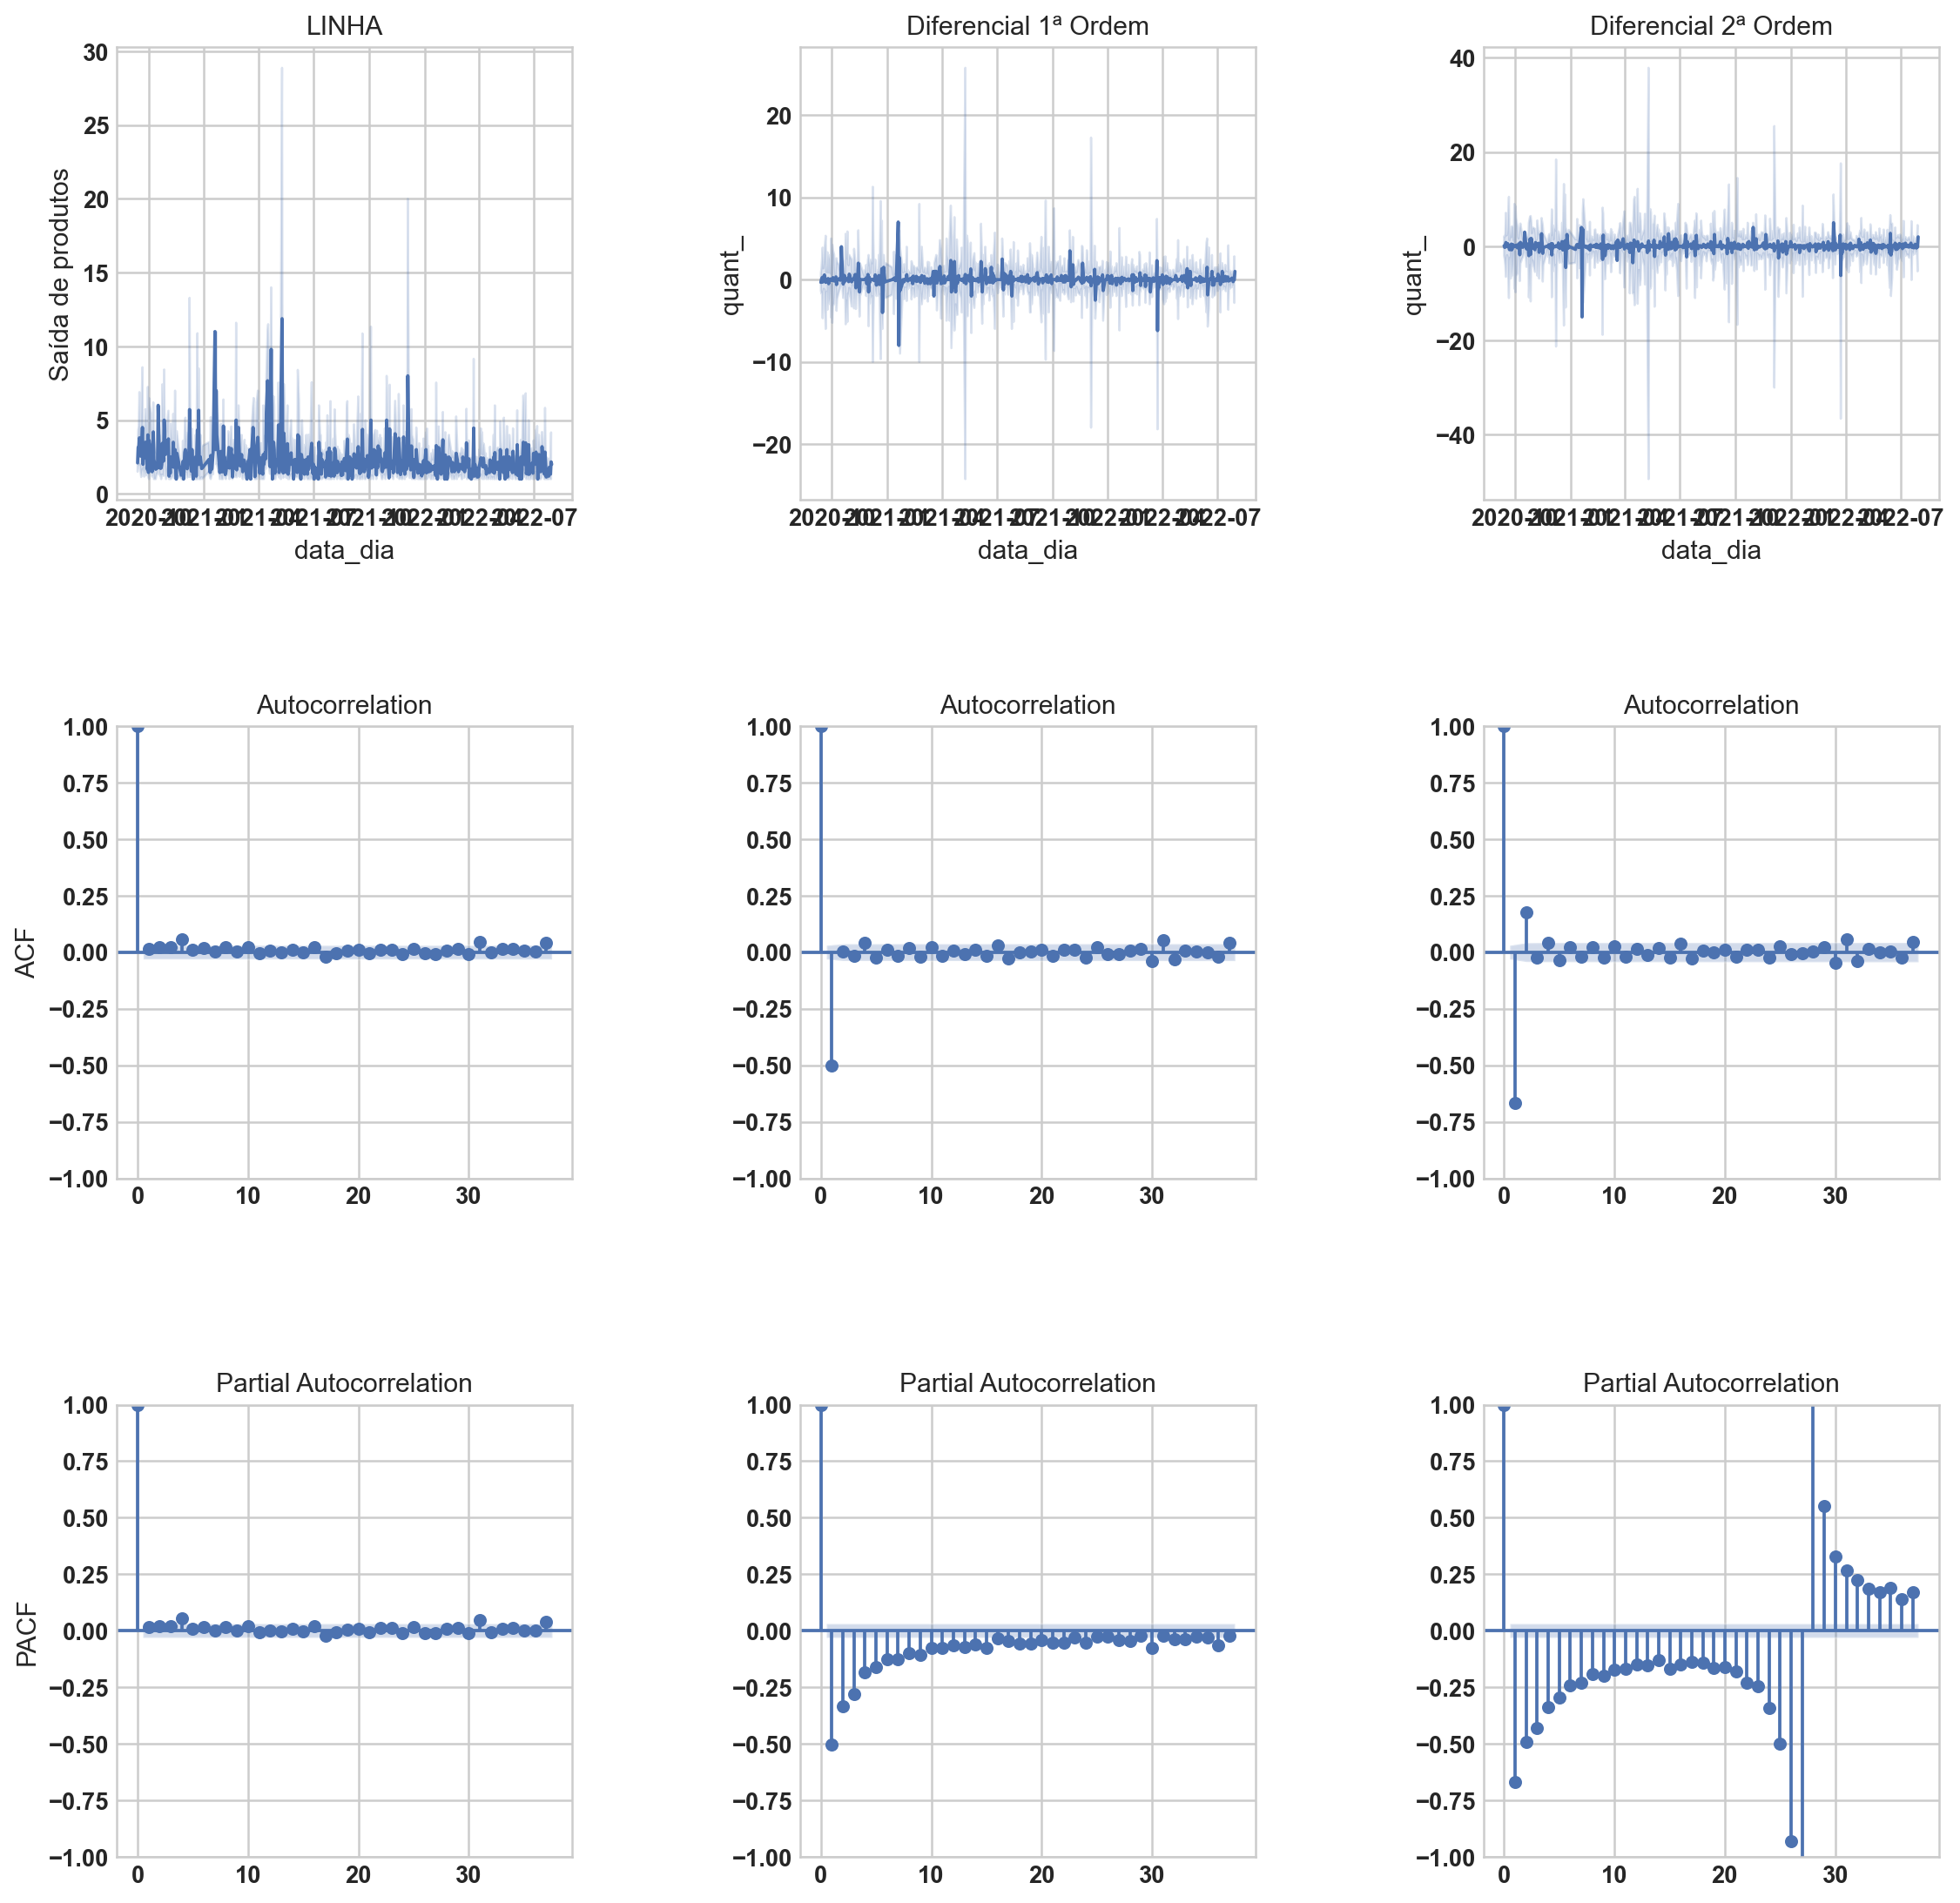

Teste de estacionariedade
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistic:  -29.49674814376636
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 2:
Test Statistic:  -19.824370048401555
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 3:
Test Statistic:  -24.410293364582373
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test:
Test Statistic:  -29.49674814376636
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 2:
Test Statistic:  -19.824370048401555
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 3:
Test Statistic:  -24.410293364582373
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test:
Test Statistic:  -29.49674814376636
p-value:  0.0
Critical Values:
	1%

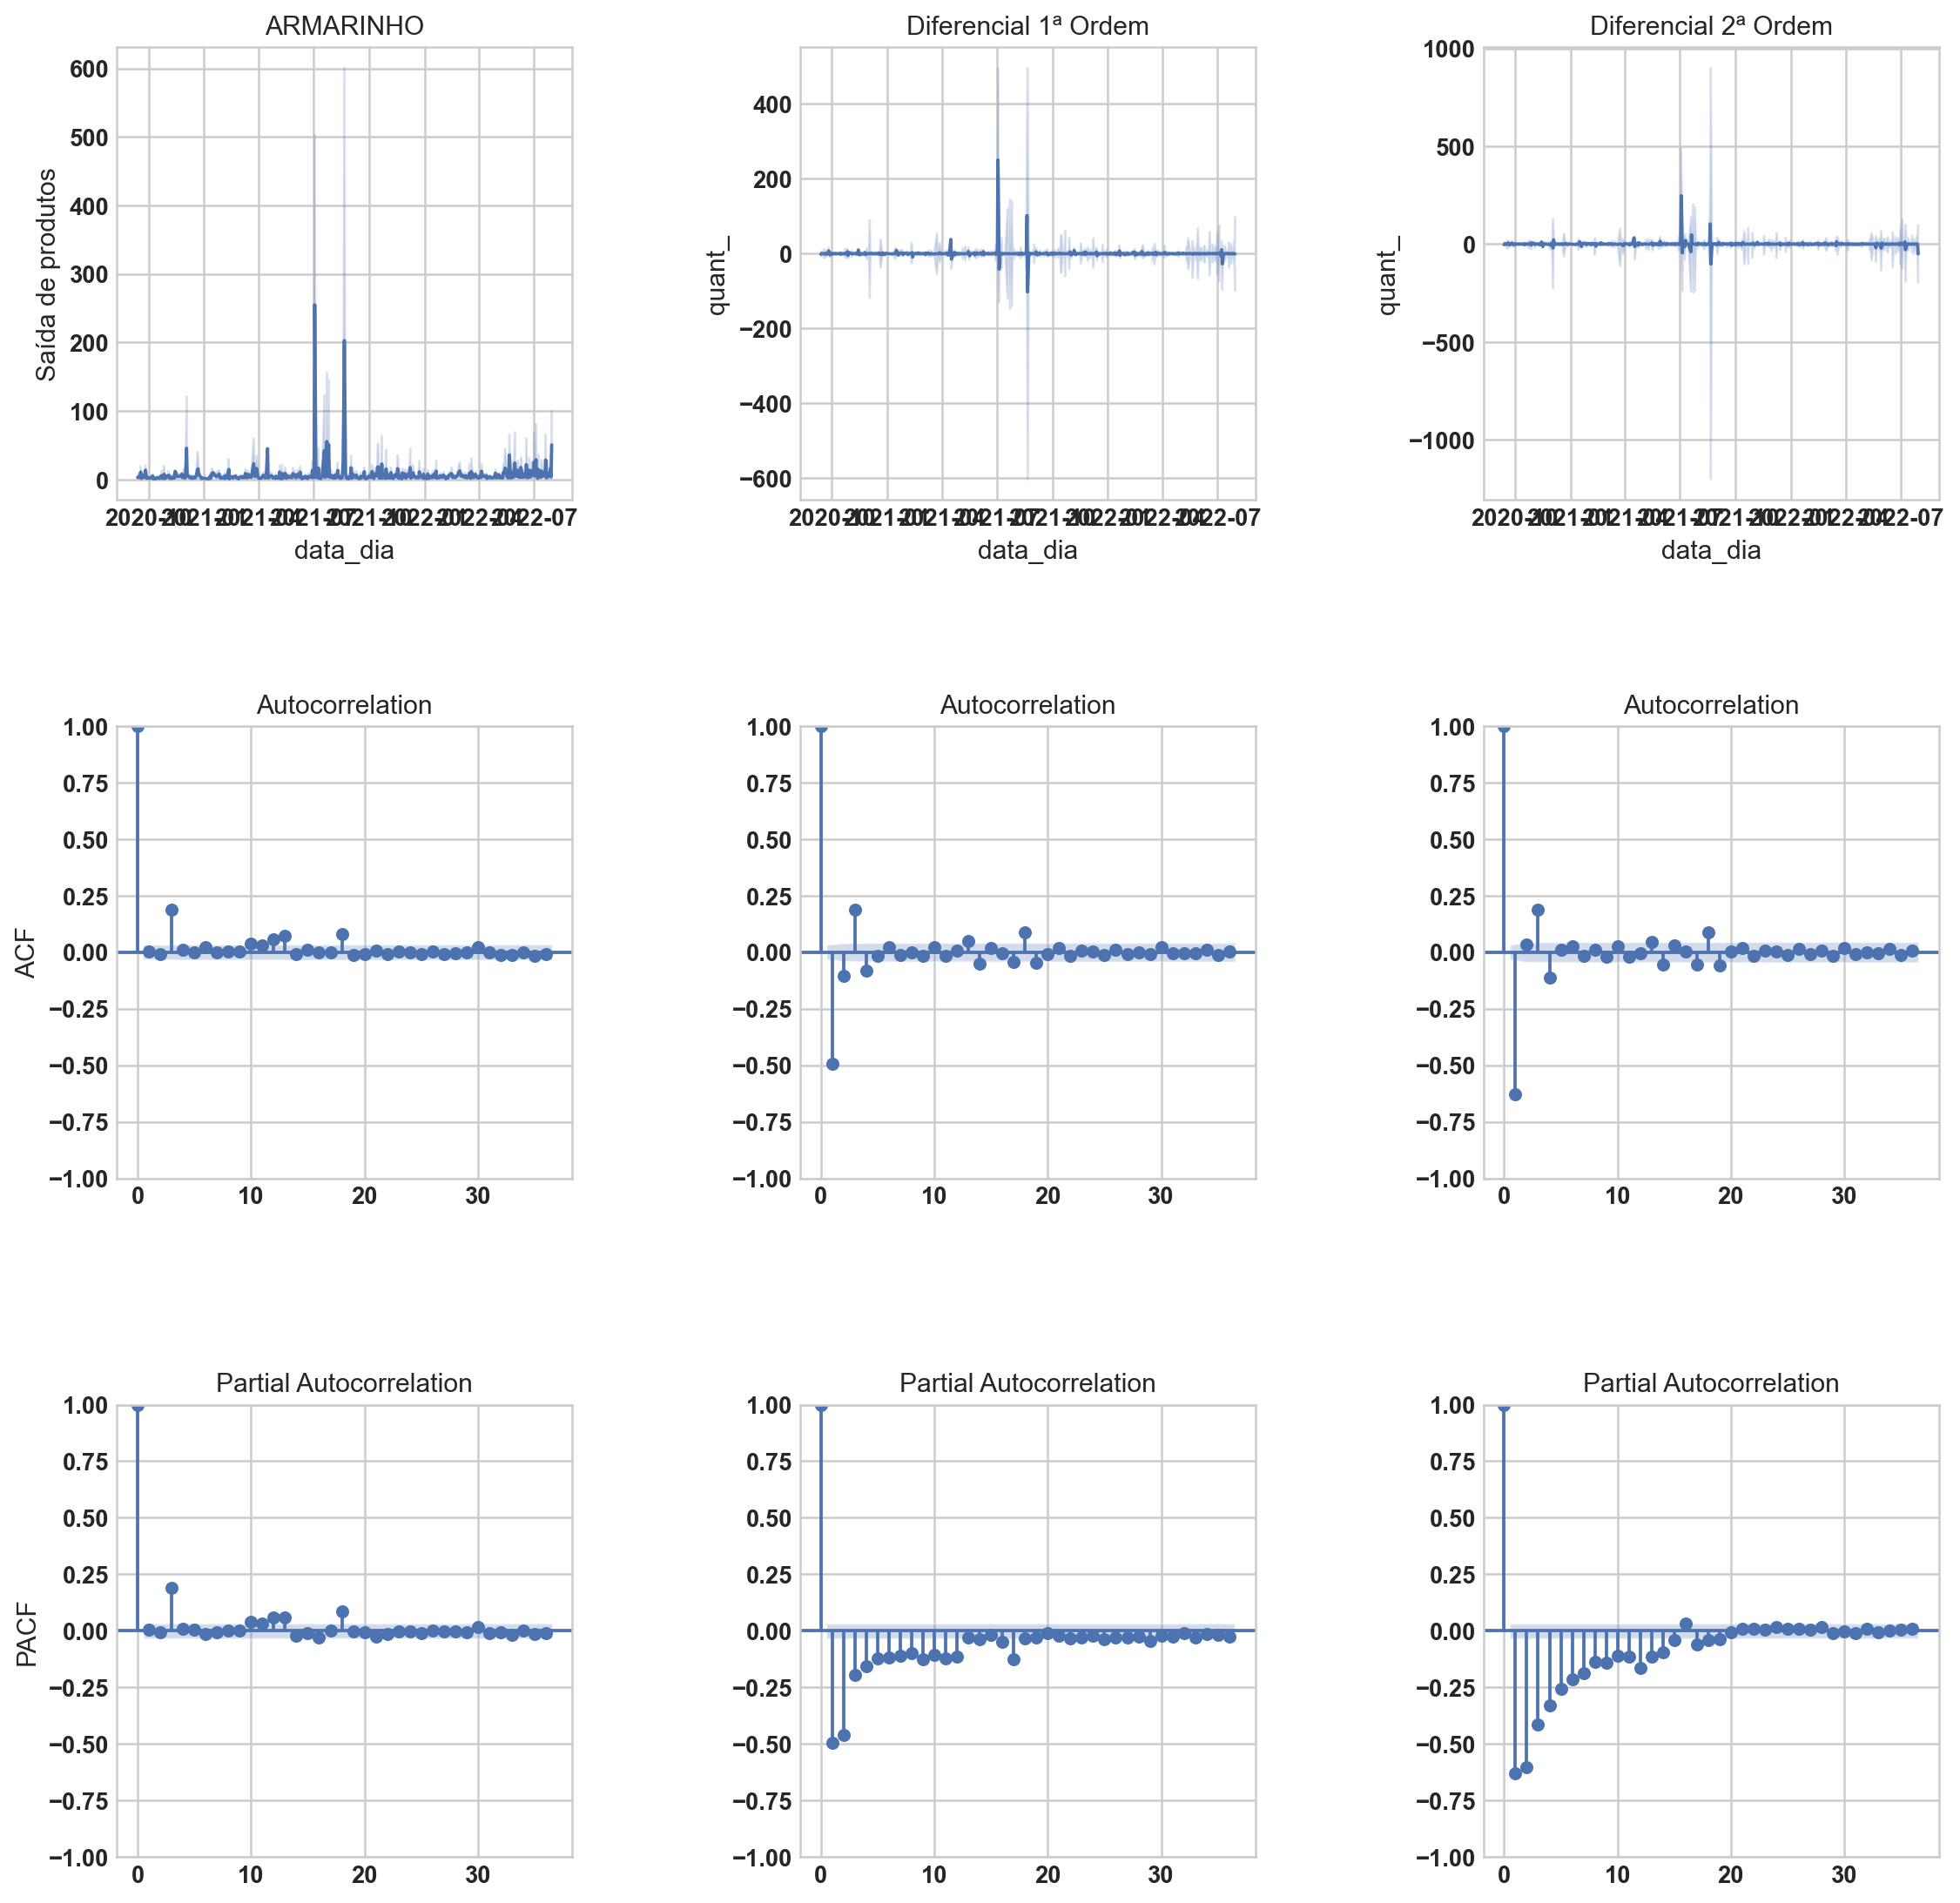

Teste de estacionariedade
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistic:  -11.764637556453987
p-value:  1.1266058334887674e-21
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 2:
Test Statistic:  -18.275228657359396
p-value:  2.3148257008638203e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 3:
Test Statistic:  -23.84921932070961
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test:
Test Statistic:  -11.764637556453987
p-value:  1.1266058334887674e-21
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 2:
Test Statistic:  -18.275228657359396
p-value:  2.3148257008638203e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller Test 3:
Test Statistic:  -23.84921932070961
p-value:  0.0
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Results of Dickey-Fuller 

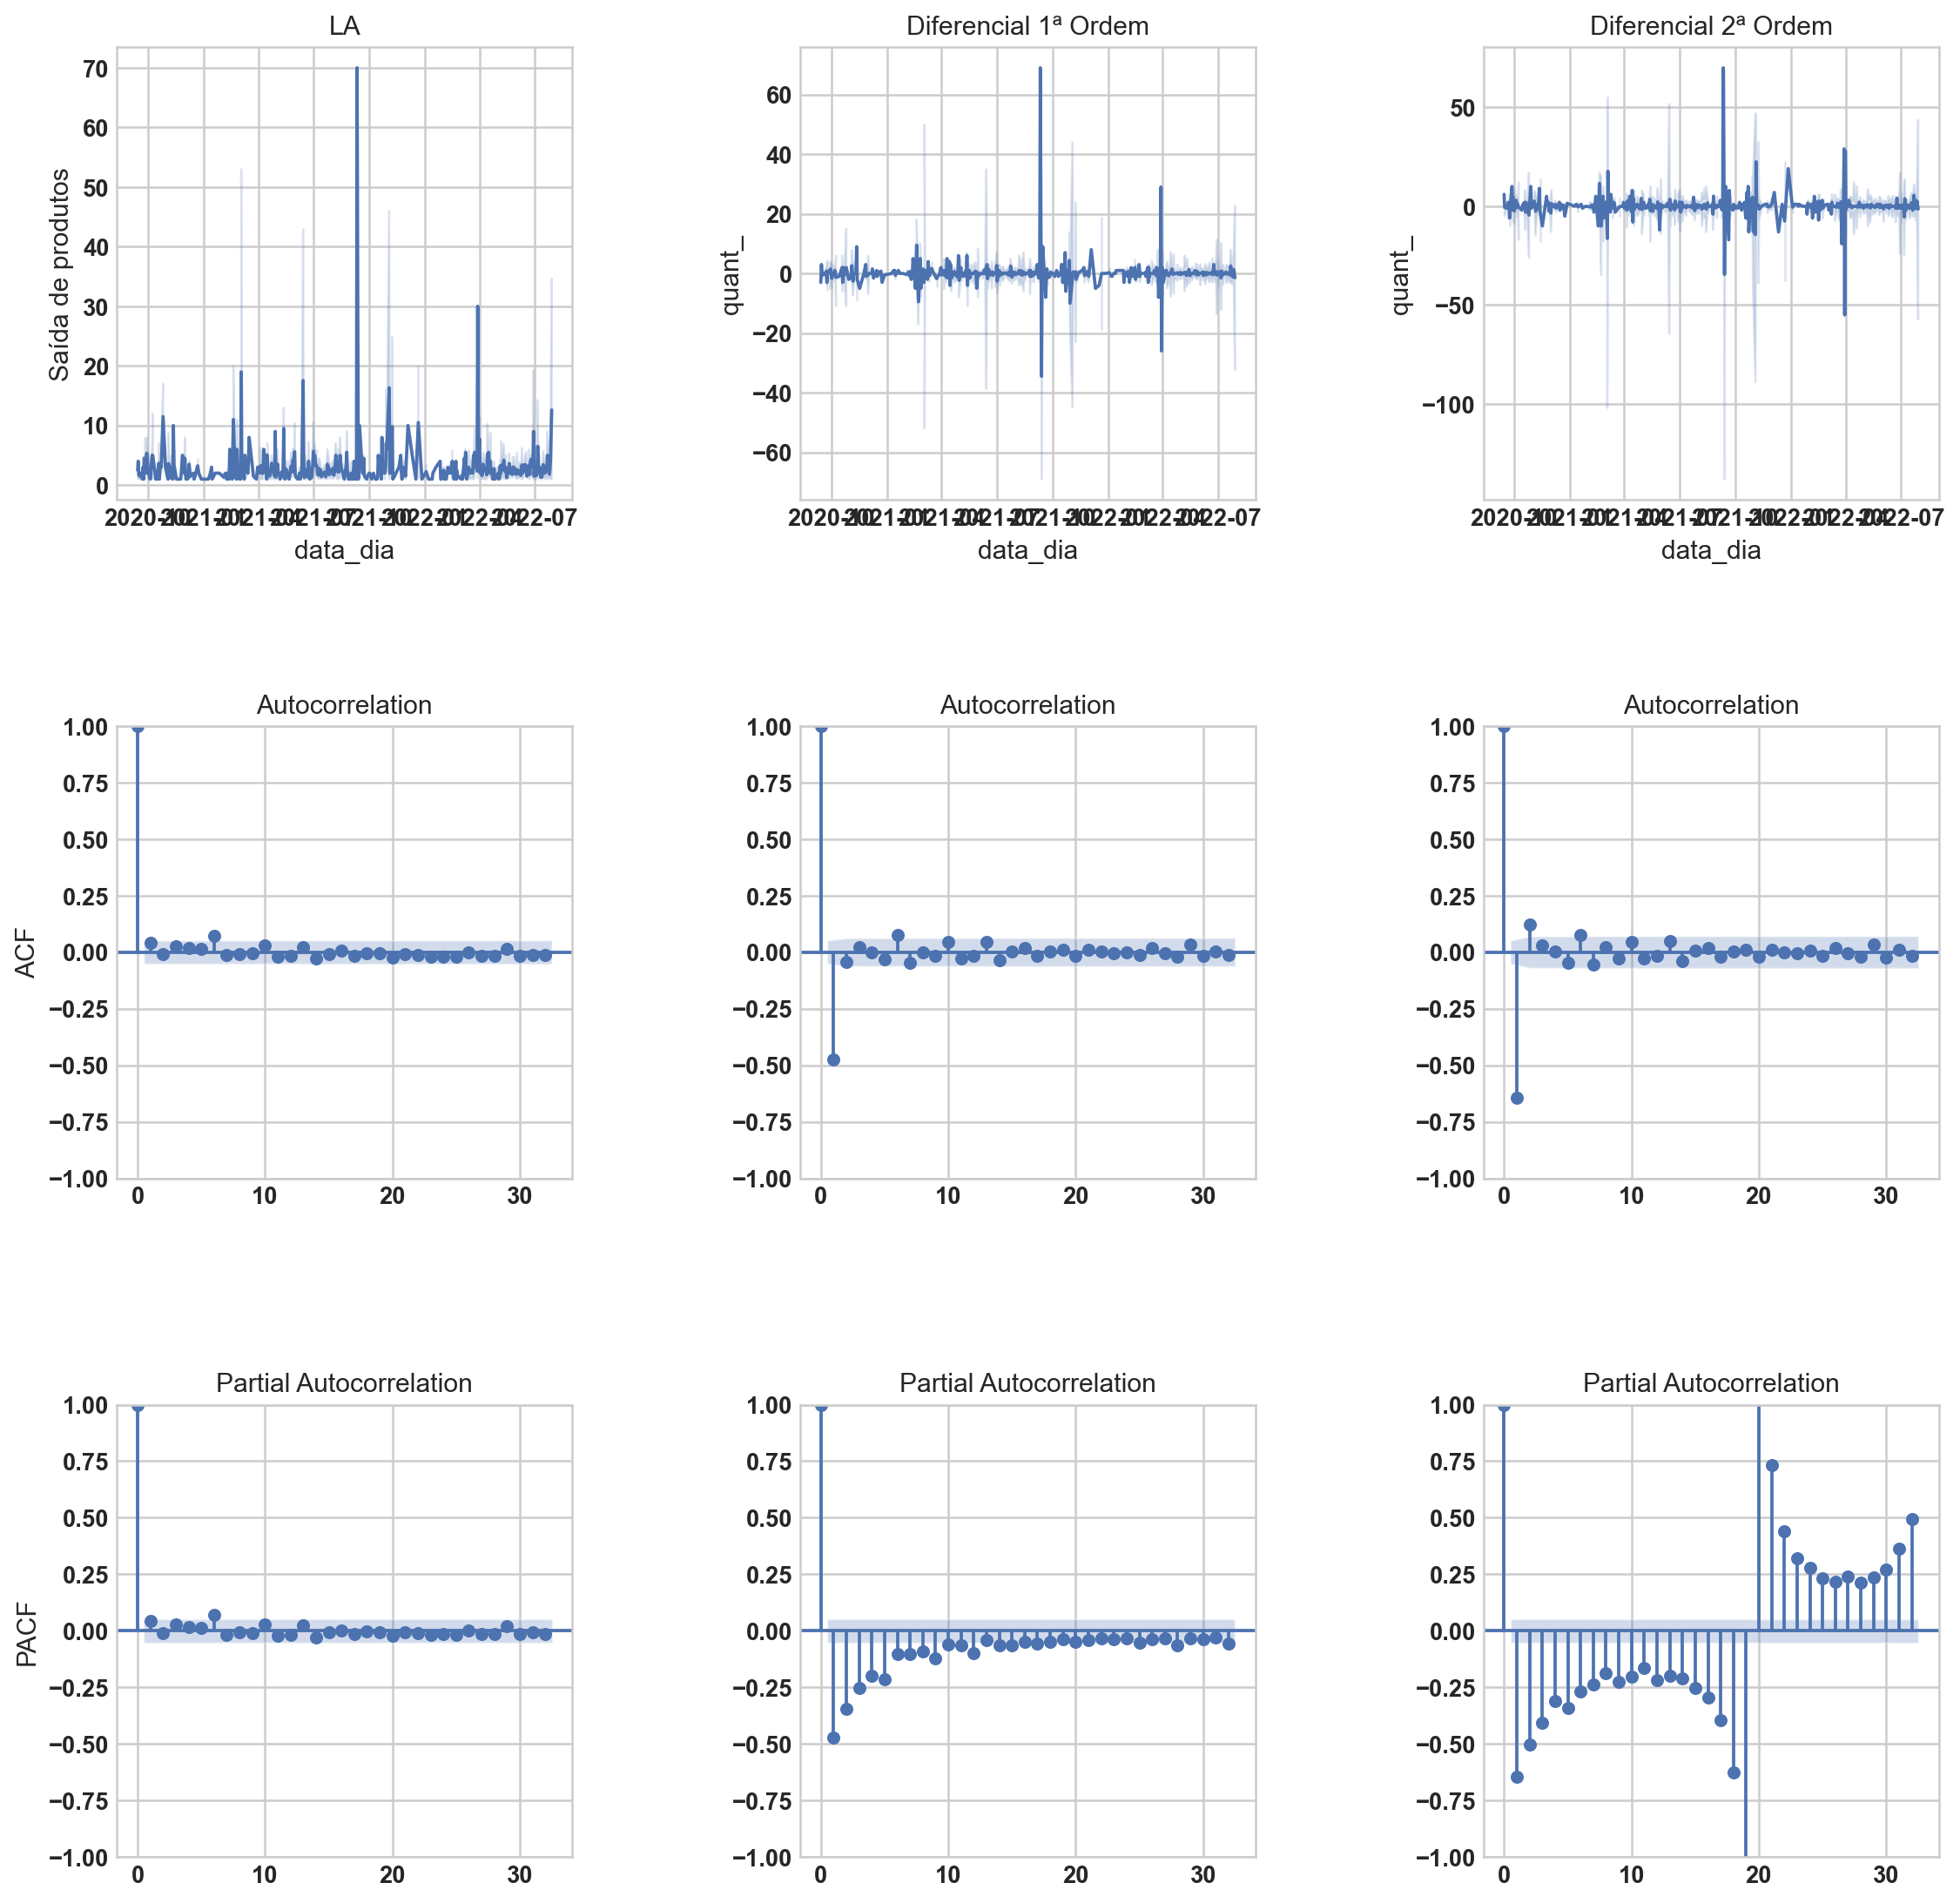

Teste de estacionariedade
--------------------------------------------------
Results of Dickey-Fuller Test:
Test Statistic:  -36.78520696012842
p-value:  0.0
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test 2:
Test Statistic:  -13.640939876350927
p-value:  1.6536231196727088e-25
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test 3:
Test Statistic:  -16.063141216749838
p-value:  5.61053165730168e-29
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test:
Test Statistic:  -36.78520696012842
p-value:  0.0
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test 2:
Test Statistic:  -13.640939876350927
p-value:  1.6536231196727088e-25
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test 3:
Test Statistic:  -16.063141216749838
p-value:  5.61053165730168e-29
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Results of Dickey-Fuller Test

In [23]:

#sns timeplot hue categoria dataframe_transacoes_produto_tratado_2 by venda and data

plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
tbl_testes = pd.DataFrame(columns=['categoria','adf','adf2','adf3','pvvalue','pvvalue2','pvvalue3','critical_value','critical_value2','critical_value3'])
tbl_testes_temp = pd.DataFrame(columns=['categoria','adf','adf2','adf3','pvvalue','pvvalue2','pvvalue3','critical_value','critical_value2','critical_value3'])
#Lista_plots = [1,2,3,4,6,7]
#create a time plot 



for categoria in dados_modelo['categoria'].unique():
    dados_modelo_categoria =dados_modelo[dados_modelo['categoria'] == categoria]
    print(categoria.upper())
    
    fig,axes = plt.subplots(3,3,figsize=(15,15),dpi = 180)
    axes[0,0].set_title('Quantidade vendas x categoria')
    axes[0,0].set_ylabel('Saída de produtos')
    axes[0,0].set_title(categoria.upper())
    axes[0,1].set_title('Diferencial 1ª Ordem')
    axes[0,2].set_title('Diferencial 2ª Ordem')
    axes[1,0].set_title('ACF sem diferencial')
    axes[1,0].set_ylabel('ACF')
    axes[1,1].set_title('ACF Diferencial 1ª Ordem')
    axes[1,2].set_title('ACF Diferencial 2ª Ordem')
    axes[2,0].set_title('PACF sem diferencial')
    axes[2,0].set_ylabel('PACF')
    axes[2,1].set_title('PACF Diferencial 1ª Ordem')
    axes[2,2].set_title('PACF Diferencial 2ª Ordem')
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

        ##axes[4].set_title('Auto Correlação parcial com diferenciação de segunda ordem')
        ##axes[4].set_xlabel('Quantidade de produtos vendidos')   

        #ax, fig = matplotlib.figure(size(Fig[4,4]))
        #
        #For i in range(len(Fig[4,4])
        #    For j in range(len(Fig[4,4]))
        #        fig.plot(lista_plots[i][j])
        #        ax.plot(fig[i,j])
    print('Gráfico de Qtd de vendas por categoria')
    try:
        sns.lineplot(x='data_dia', y=(dados_modelo_categoria['quant_']), data=dados_modelo_categoria,ax=axes[0,0]) #0
        sns.lineplot(x='data_dia', y=(dados_modelo_categoria['quant_'].diff()), data=dados_modelo_categoria,ax=axes[0,1]) #0
        sns.lineplot(x='data_dia', y=(dados_modelo_categoria['quant_'].diff().diff()), data=dados_modelo_categoria,ax=axes[0,2]) #   
    except:
        print('categoria {0} não possui dados suficientes para plotar gráfico'.format(categoria)) 
    
    print('-'*50)
    print('Gráficos de autocorrelação e autocorrelação parcial')
    print('-'*50)
    print('Gráfico de autocorrelação')
    try:
        plot_acf(dados_modelo_categoria['quant_'],ax=axes[1,0])    #1
    except:
        print('Erro ao plotar autocorrelação')
    try:
        plot_acf(dados_modelo_categoria['quant_'].diff().dropna(),ax=axes[1,1]) #2
    except:
        print('Erro ao plotar autocorrelação')
    try:    
        plot_acf(dados_modelo_categoria['quant_'].diff().diff().dropna(),ax=axes[1,2]) #3
    except:
        print('Erro ao plotar autocorrelação')
    print('-'*50)
    print('Gráfico de autocorrelação parcial')
    try:
        plot_pacf(dados_modelo_categoria['quant_'],ax=axes[2,0]) #4
    except:
        print('Erro ao plotar autocorrelação parcial')
    try:    
        plot_pacf(dados_modelo_categoria['quant_'].diff().dropna(),ax=axes[2,1] ) #5
    except:
        print('Erro ao plotar autocorrelação parcial')
    try:    
        plot_pacf(dados_modelo_categoria['quant_'].diff().diff().dropna(),ax=axes[2,2]) #6
    except:
        print('Erro ao plotar autocorrelação parcial')
    print('-'*50)
    plt.show()
    
    print('Teste de estacionariedade')
    print('-'*50)
    try:
        check_stationarity(dados_modelo_categoria['quant_'])
        tbl_testes_temp['categoria'] = categoria
        tbl_testes_temp['adf'] = check_stationarity(dados_modelo_categoria['quant_'])[0]
        tbl_testes_temp['adf2'] = check_stationarity(dados_modelo_categoria['quant_'])[1]
        tbl_testes_temp['adf3'] = check_stationarity(dados_modelo_categoria['quant_'])[2]
        tbl_testes_temp['pvvalue'] = check_stationarity(dados_modelo_categoria['quant_'])[3]
        tbl_testes_temp['pvvalue2'] = check_stationarity(dados_modelo_categoria['quant_'])[4]
        tbl_testes_temp['pvvalue3'] = check_stationarity(dados_modelo_categoria['quant_'])[5]
        tbl_testes_temp['critical_value'] = check_stationarity(dados_modelo_categoria['quant_'])[6].get('1%')
        tbl_testes_temp['critical_value2'] = check_stationarity(dados_modelo_categoria['quant_'])[7].get('5%')
        tbl_testes_temp['critical_value3'] = check_stationarity(dados_modelo_categoria['quant_'])[8].get('10%')
        tbl_testes = tbl_testes.append(tbl_testes_temp)
    except:
        print('categoria {0} não possui dados suficientes ser testada no método de Dickey Fulley'.format(categoria))


#       
# 
# print('Decomposição da série temporal aditiva')
#   decompose = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='additive', period=30)
#   print('Decomposição da série temporal multiplicativa de primeira ordem')
#   decompose2 = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='aditive', period=30)
#   print('Decomposição da série temporal multiplicativa de segunda ordem')
#   decompose3 = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='aditive', period=30, extrapolate_trend='freq')



In [28]:
tbl_testes.drop_duplicates(inplace=True,keep='last')
df_plt_testes = tbl_testes.head(24).reset_index(drop=True)
df_plt_testes

,categoria,adf,adf2,adf3,pvvalue,pvvalue2,pvvalue3,critical_value,critical_value2,critical_value3


In [43]:

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
modelo = dados_modelo.query('categoria == "linha"')
dado = modelo[['mes_ano','quant_']].groupby(['mes_ano']).sum()
dado




,quant_
mes_ano,
2020-09,497.0
2020-10,584.0
2020-11,354.0
2020-12,493.0
2021-01,258.0
...,...
2022-03,402.0
2022-04,346.0
2022-05,361.0


In [44]:

p = 1
q = 1
d = 4
arima_model = sm.tsa.arima.ARIMA(dado, order=(p,q,d))
arima_model.fit()
print(arima_model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 quant_   No. Observations:                   23
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -127.082
Date:                Sat, 15 Oct 2022   AIC                            266.163
Time:                        21:16:30   BIC                            272.710
Sample:                    09-01-2020   HQIC                           267.705
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8414      0.604     -1.393      0.164      -2.026       0.343
ma.L1          0.0258    823.781   3.13e-05      1.000   -1614.556    1614.607
ma.L2         -0.4847    731.037     -0.001      0.9

In [92]:

p = 1
q = 1
d = 4
P = 1
Q = 1
D = 1
m = 12

sarima_model = sm.tsa.statespace.SARIMAX(dado, order=(p,q,d), seasonal_order=(P,Q,D,m))
results = sarima_model.fit()
print(results.summary())


                                      SARIMAX Results                                       
Dep. Variable:                               quant_   No. Observations:                   23
Model:             SARIMAX(1, 1, 4)x(1, 1, [1], 12)   Log Likelihood                 -59.968
Date:                              Sat, 15 Oct 2022   AIC                            135.935
Time:                                      22:13:56   BIC                            138.356
Sample:                                  09-01-2020   HQIC                           133.280
                                       - 07-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6482      8.805     -0.074      0.941     -17.905      16.608
ma.L1         -0.20

<AxesSubplot:xlabel='mes_ano', ylabel='quant_'>

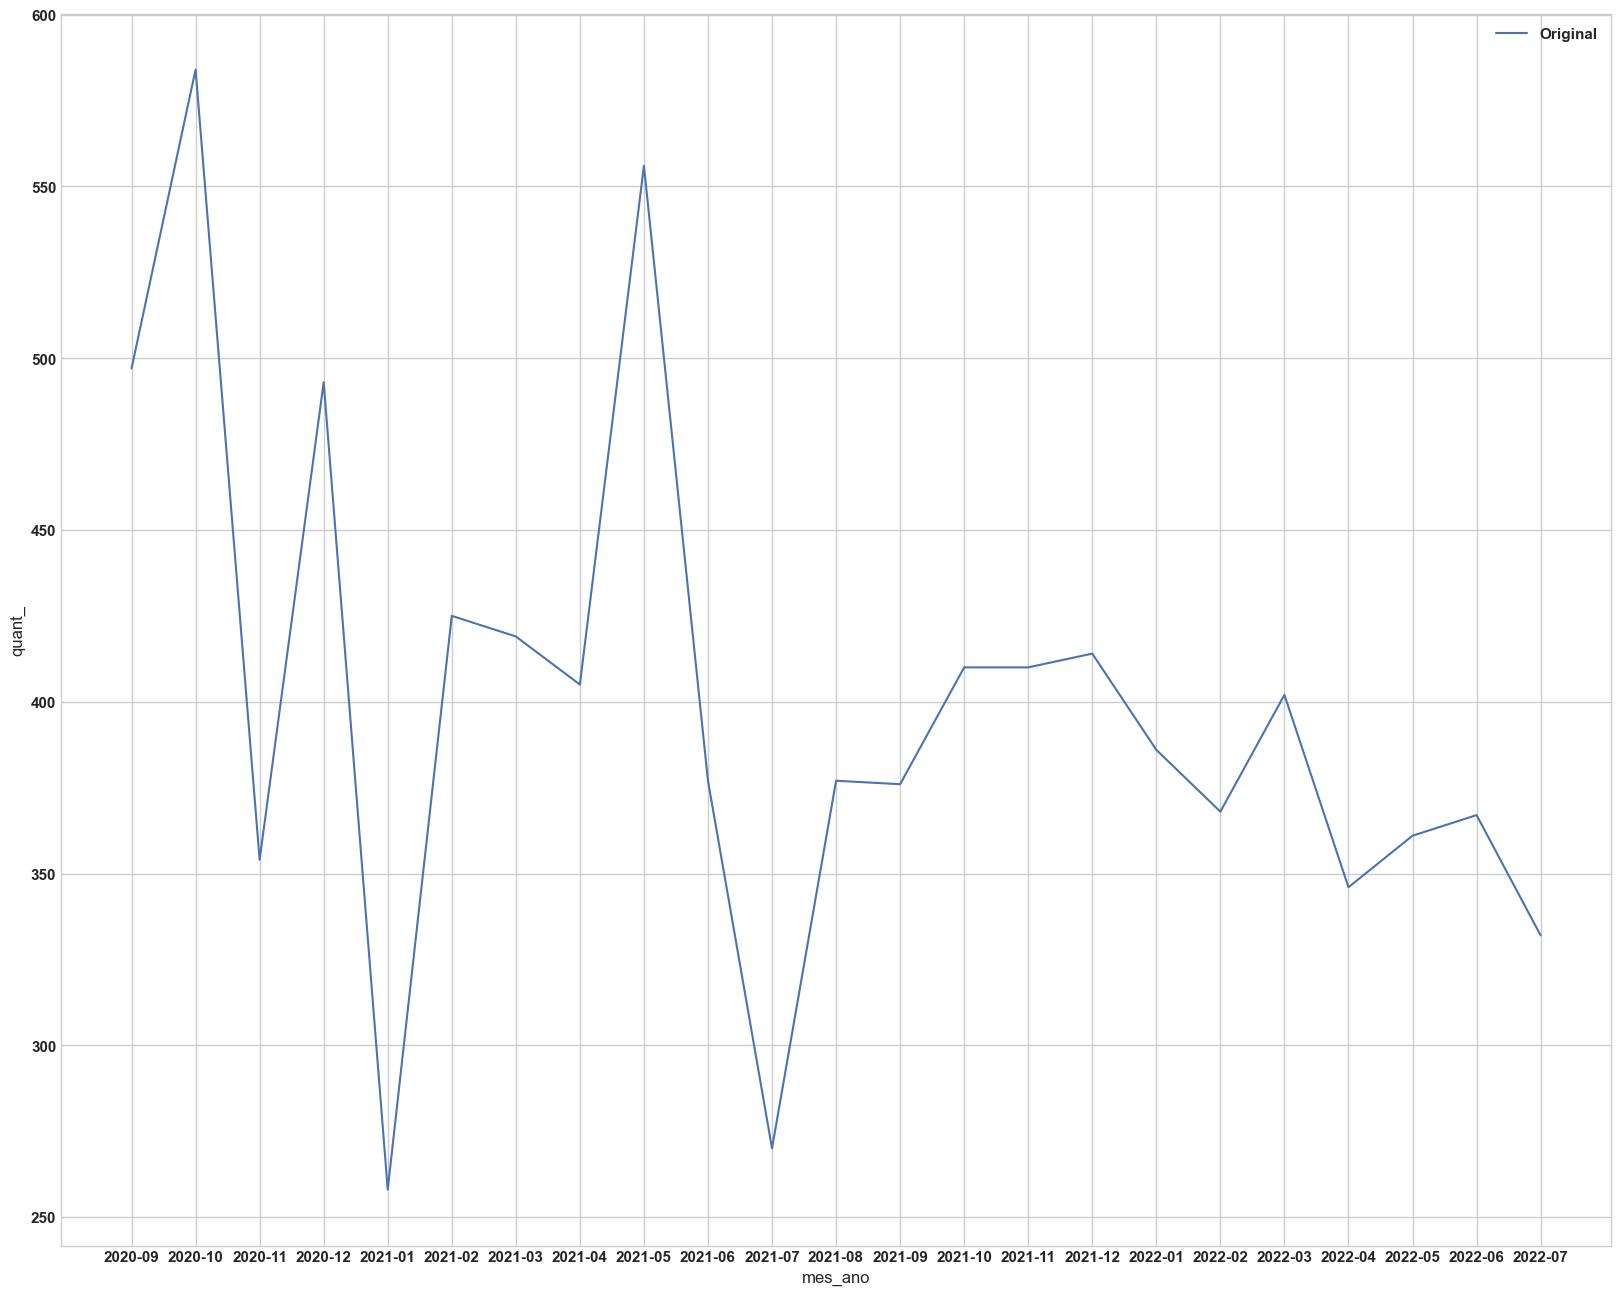

In [93]:
fig, ax1 = plt.subplots(figsize=(20, 16), dpi=100)

plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
sns.lineplot(x=dado.index, y=dado['quant_'], label='Original')


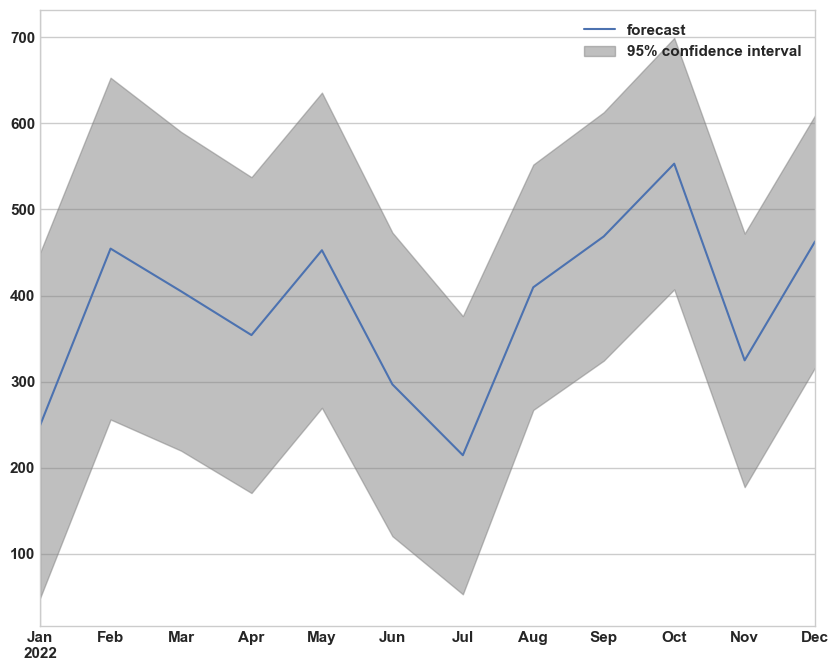

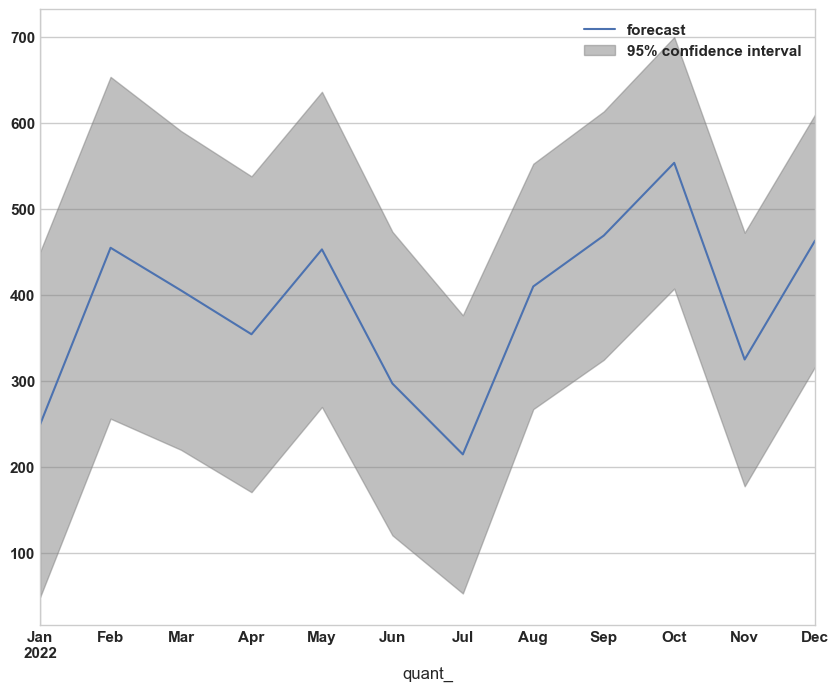

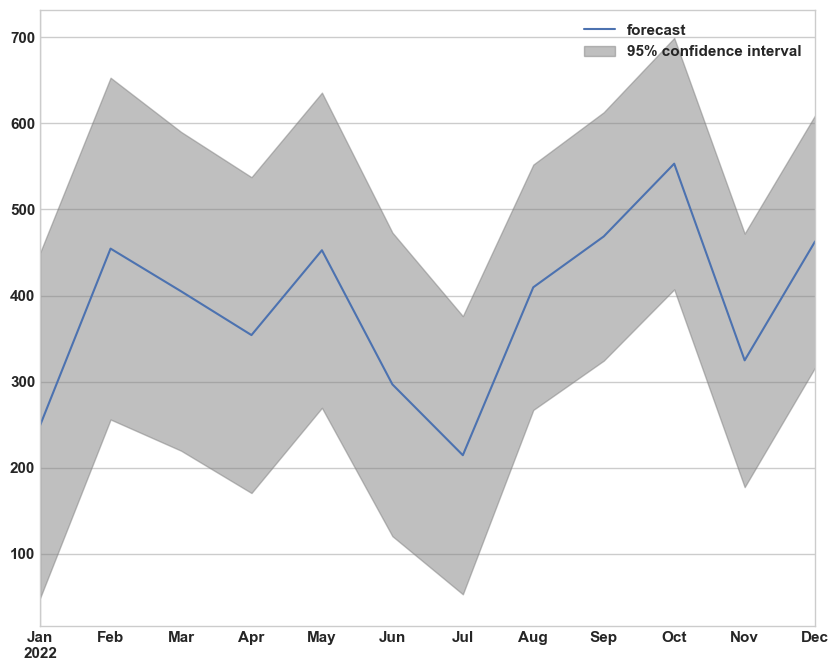

In [95]:

# Actual vs Fitted
plot_predict(sarima_model.fit(),dpi = 100,start ='2022-01-01', end= '2022-12-01', lags=4)
sns.lineplot(dado['quant_'],color='red')
plot_predict(sarima_model.fit(), dpi=100, plot_insample=False,dynamic=False, lags=4, start='2022-01-01', end='2022-12-01')

In [101]:
dt_ar = pd.date_range(start='2022-01-01', end='2022-12-01', freq='MS')
dt_ar

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01'], dtype='datetime64[ns]', freq='MS')

<AxesSubplot:xlabel='mes_ano', ylabel='quant_'>

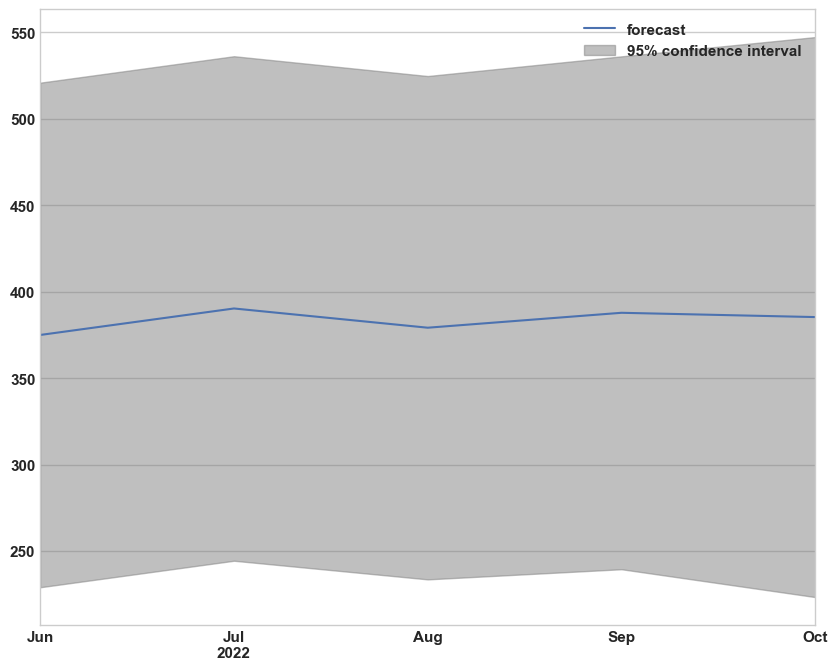

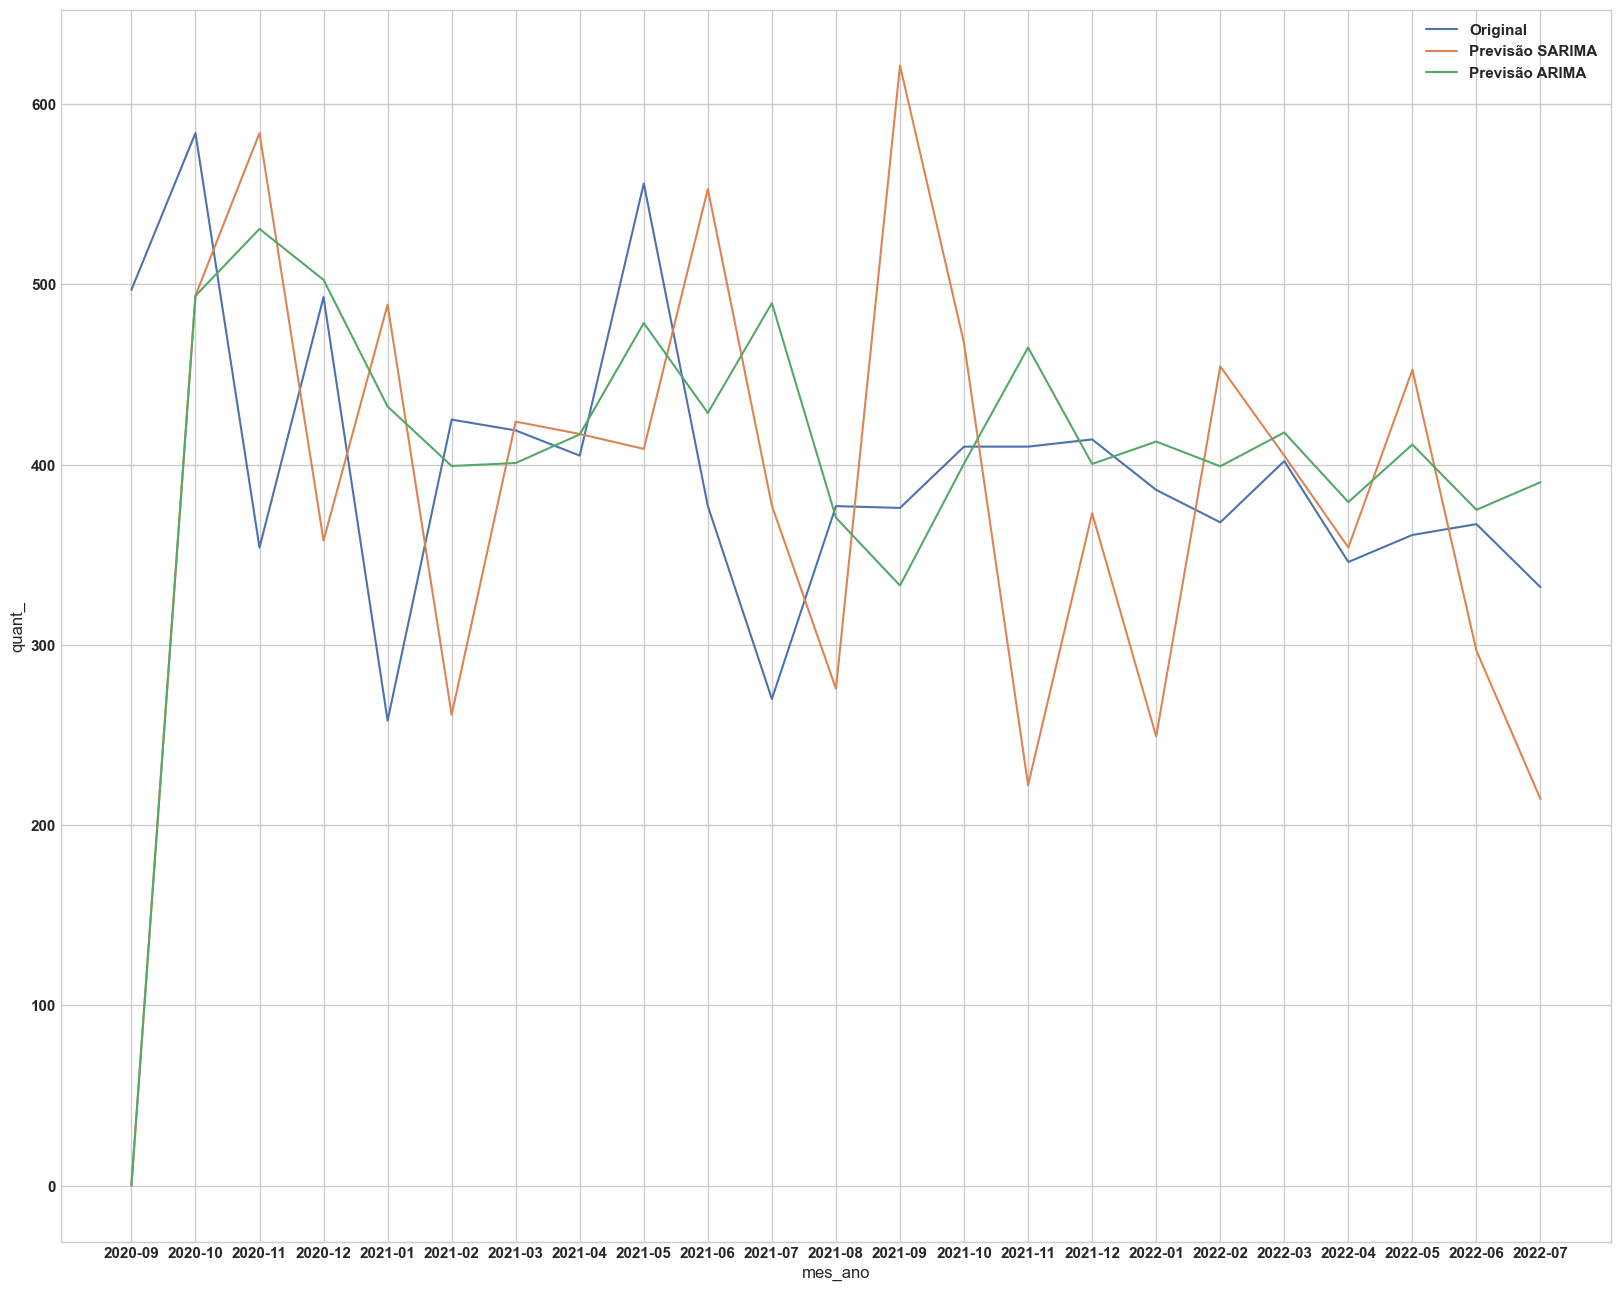

In [104]:

plot_predict(arima_model.fit(),dpi = 100,start ='2022-06-01', end= '2022-10-01', lags=4,)
fig, ax1 = plt.subplots(figsize=(20, 16), dpi=100)

plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)
sns.lineplot(x=dado.index, y=dado['quant_'], label='Original')
sns.lineplot(x=dado.index, y=results.predict(), label='Previsão SARIMA')
sns.lineplot(x=dado.index, y=arima_model.fit().predict(), label='Previsão ARIMA')

<module 'matplotlib.pyplot' from 'c:\\Users\\otavi\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

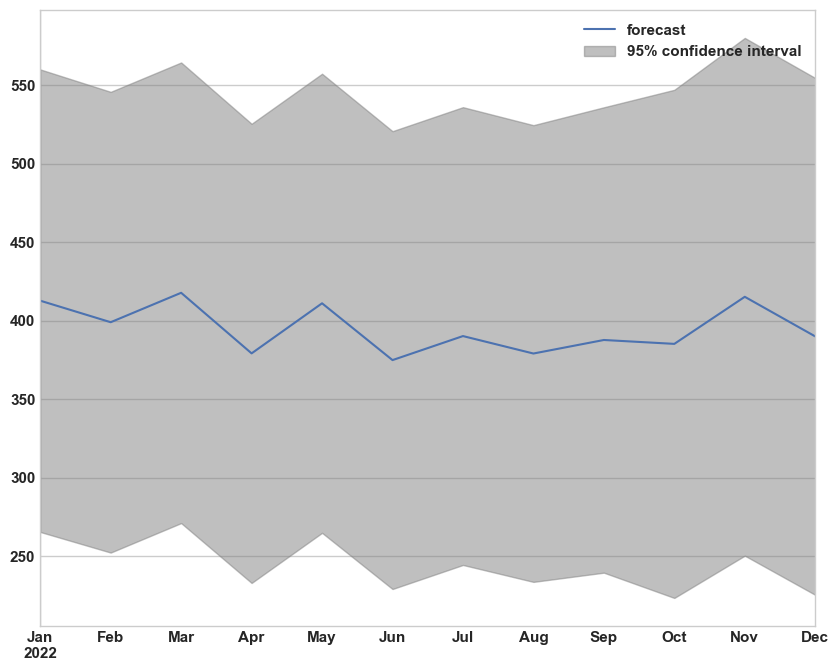

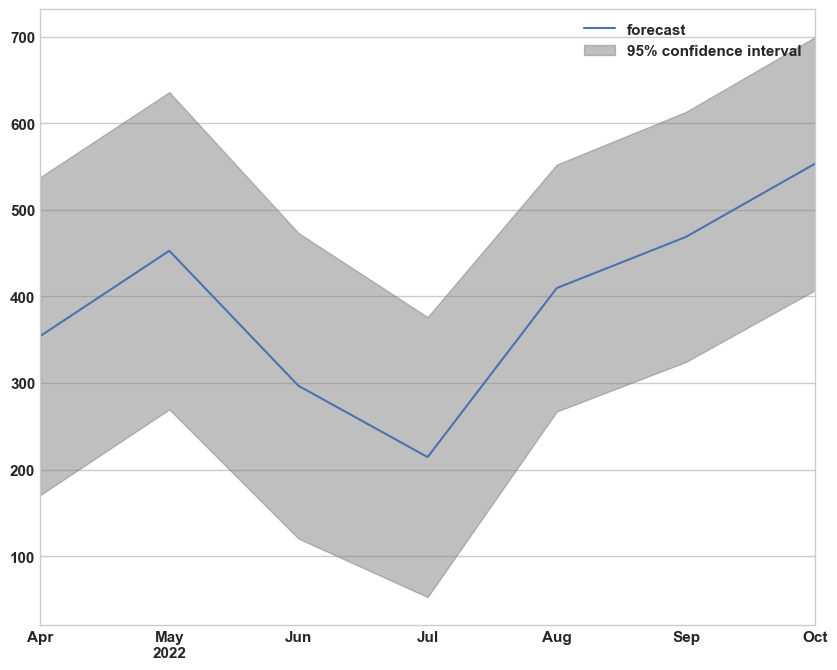

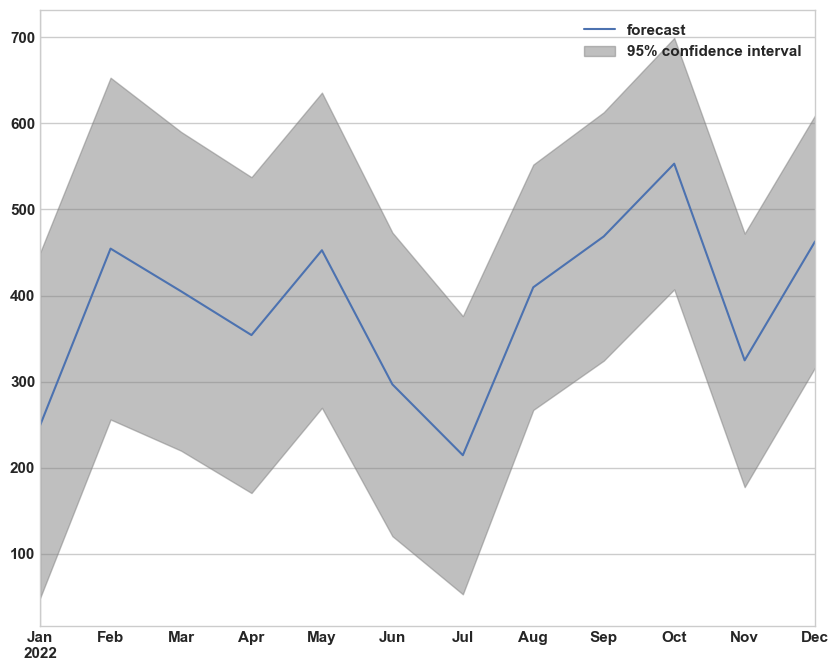

In [82]:

# Actual vs Fitted

plot_predict(arima_model.fit(),dpi = 100,start ='2022-01-01', end= '2022-12-01', lags=4,)


# Actual vs Fitted
plot_predict(sarima_model.fit(),dpi = 100,start ='2022-04-01', end= '2022-10-01', lags=4)
plot_predict(sarima_model.fit(), dpi=100, plot_insample=False,dynamic=False, lags=4,start='2022-01-01', end='2022-12-01')
plt

In [105]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [106]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [107]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [110]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

>expected=377.0, predicted=381.1
>expected=376.0, predicted=377.0
>expected=410.0, predicted=395.1
>expected=410.0, predicted=539.6
>expected=414.0, predicted=392.2
>expected=386.0, predicted=291.9
>expected=368.0, predicted=394.2
>expected=402.0, predicted=377.5
>expected=346.0, predicted=400.6
>expected=361.0, predicted=401.4
>expected=367.0, predicted=384.8
>expected=332.0, predicted=373.8
MAE: 39.235


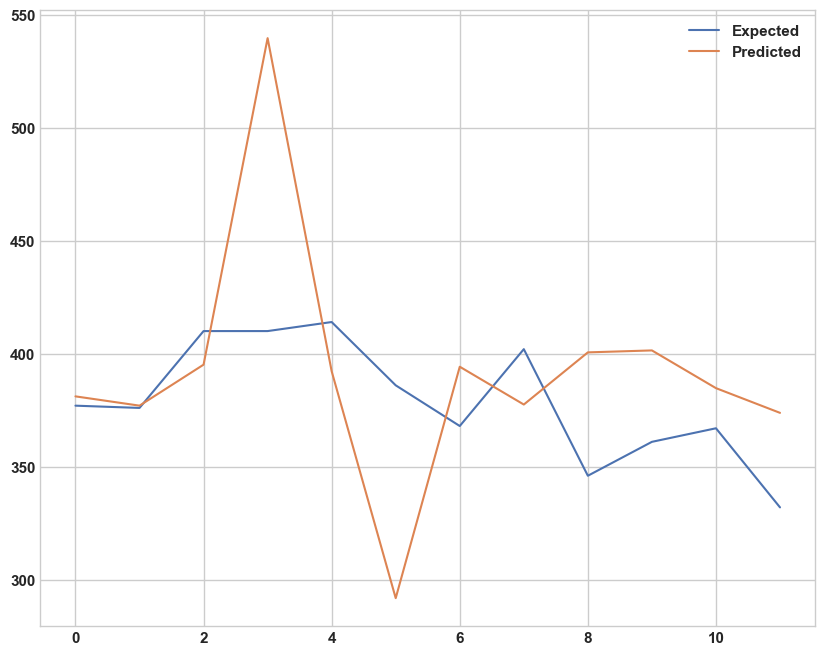

In [113]:

 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
series = dado
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()